# Optical recordings processing with pyCardiac

This notebook demonstrates general pipeline of processing and analysis of Action Potential optical recordings.

Please go through this notebook step by step. 

## Content

* 1. <a href="#section1" > Data loading </a>

* 2. <a href="#section2" > Processing </a>
    * 2.1. <a href="#section2.1" > Fourier filtration</a>
    * 2.2. <a href="#section2.2" > Baseline removal </a>
    * 2.3. <a href="#section2.3" > Binning (spatial filtration) </a>
    * 2.4. <a href="#section2.4" > Rescaling (normalizing) </a>
    * 2.5. <a href="#section2.5" > Ensemble averaging </a>
    * 2.6. <a href="#section2.6" > Transform to phase </a>
    
* 3.<a href="#section3" > Mapping </a>
    * 3.1. <a href="#section3.1" > APD and Alternance maps </a>
    * 3.2. <a href="#section3.2" > Activation time map </a>
    * 3.3. <a href="#section3.3" > Phase singularity points (PS) </a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyCardiac as pc
from pyCardiac.rhythm import *
from pyCardiac.signal.analysis import phase_singularity_detection

<a id='section1'></a>
## Data loading

In [3]:
data_raw_filename = "./source/sample_optical_recordings.npy"
data_raw = np.load(data_raw_filename)

<a id='section2'></a>
## Processing

In [4]:
data = data_raw.copy()
mask = np.loadtxt("./source/sample_optical_recordings_mask.txt").astype(np.bool)
x, y, t = 80, 60, 10

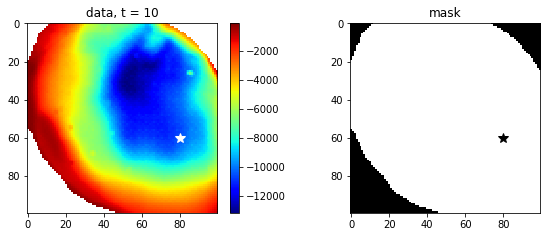

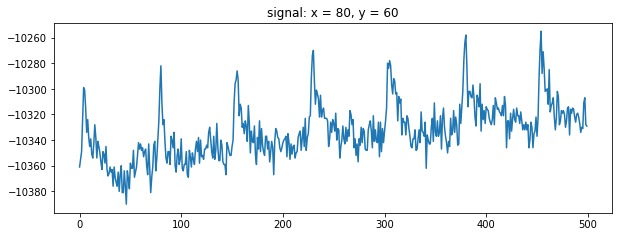

In [5]:
plt.figure(figsize = (10, 3.5))

plt.subplot(1, 2, 1)
frame = np.ma.masked_where(~mask, data[:, :, t])
plt.imshow(frame, cmap="jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data, t = {t}".format(t = t))

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap = "Greys_r")
plt.plot(x, y, '*k', ms = 10)
plt.title("mask")

plt.show()

plt.figure(figsize = (10, 3.5))
plt.plot(data[y, x, :])
plt.title("signal: x = {x}, y = {y}".format(x=x, y=y))
plt.show()

<a id='section2.1'></a>
### Fourier filtration

In [6]:
Fs = 1000.                    # sampling frequency
interval_to_trim = [0, 150]   # remove frequencies greater than 150Hz
interval_to_remove = [62, 58] # remove 60Hz hum
args = (Fs, interval_to_trim, interval_to_remove)
%time data_filtered = fourier_filter(data, *args)

CPU times: user 864 ms, sys: 23.7 ms, total: 888 ms
Wall time: 886 ms


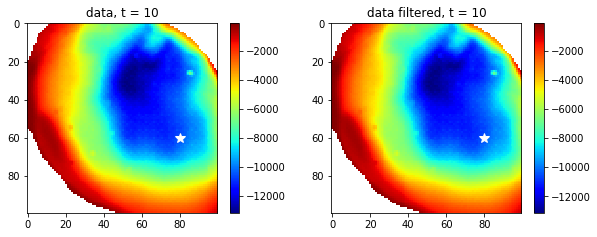

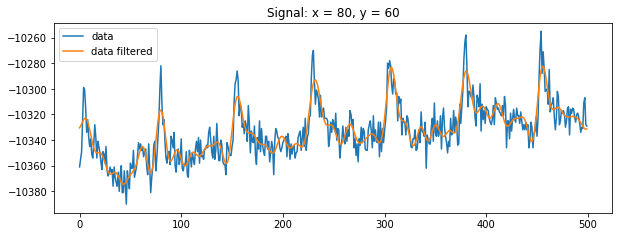

In [7]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2, 1)
frame = np.ma.masked_where(~mask, data[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data, t = {t}".format(t = t))

plt.subplot(1, 2, 2)
frame = np.ma.masked_where(~mask, data_filtered[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data filtered, t = {t}".format(t = t))

plt.show()

plt.figure(figsize = (10, 3.5))
plt.plot(data[y, x, :],
         label = "data", color = "C0")
plt.plot(data_filtered[y, x, :],
         label = "data filtered", color = "C1")
plt.title("Signal: x = {x}, y = {y}".format(x=x, y=y))
plt.legend()
plt.show()

<a id='section2.2'></a>
### Baseline removal

In [8]:
#Linear detrending
%time data_detrended = remove_baseline(data_filtered)

# Asymmetric-Least-Squares Method (slow but more powerful)
# uncomment to use
#niter = 2
#%time data_detrended = remove_baseline(data_filtered, method_name="least_squares", niter = niter)

CPU times: user 8.26 s, sys: 312 ms, total: 8.57 s
Wall time: 4.29 s


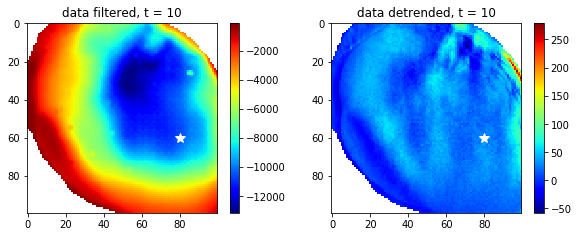

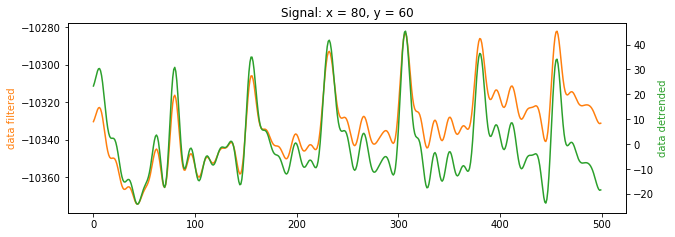

In [9]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2, 1)
frame = np.ma.masked_where(~mask, data_filtered[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data filtered, t = {t}".format(t = t))

plt.subplot(1, 2, 2)
frame = np.ma.masked_where(~mask, data_detrended[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data detrended, t = {t}".format(t = t))

plt.show()


fig, ax1 = plt.subplots(figsize = (10, 3.5))
ax1.plot(data_filtered[y, x, :], color = "C1")
ax1.set_title("Signal: x = {x}, y = {y}".format(x=x, y=y))
ax1.set_ylabel("data filtered", color='C1')

ax2 = ax1.twinx()
ax2.plot(data_detrended[y, x, :], color = "C2")
ax2.set_ylabel("data detrended", color='C2')
plt.show()

<a id='section2.3'></a>
### Binning (spatial filtration)

In [10]:
%time data_binned = binning(data_detrended, 9, "gaussian", mask)

CPU times: user 1.23 s, sys: 7.97 ms, total: 1.24 s
Wall time: 1.24 s


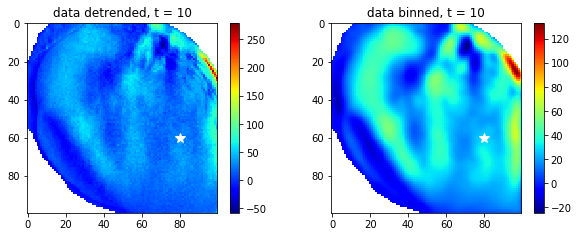

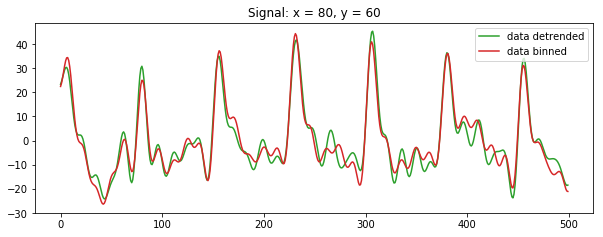

In [11]:
plt.figure(figsize = (10, 3.5))

plt.subplot(1, 2, 1)
frame = np.ma.masked_where(~mask, data_detrended[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data detrended, t = {t}".format(t = t))

plt.subplot(1, 2, 2)
frame = np.ma.masked_where(~mask, data_binned[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data binned, t = {t}".format(t = t))

plt.show()

plt.figure(figsize = (10, 3.5))
plt.plot(data_detrended[y, x, :],
         label = "data detrended", color = "C2")
plt.plot(data_binned[y, x, :],
         label = "data binned", color = "C3")
plt.title("Signal: x = {x}, y = {y}".format(x=x, y=y))
plt.legend()
plt.show()

<a id='section2.4'></a>
### Rescaling (normalizing)

In [12]:
%time data_rescaled = rescale(data_binned)

/home/andrey/WORK/bin/miniconda3/lib/python3.7/site-packages/pyCardiac/routines/routines.py:24: RuntimeWarning: invalid value encountered in true_divide
  result /= np.nanmax(result)


CPU times: user 482 ms, sys: 32.1 ms, total: 514 ms
Wall time: 512 ms


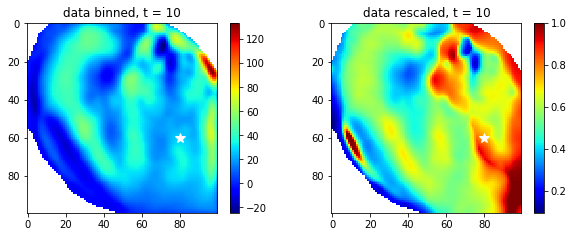

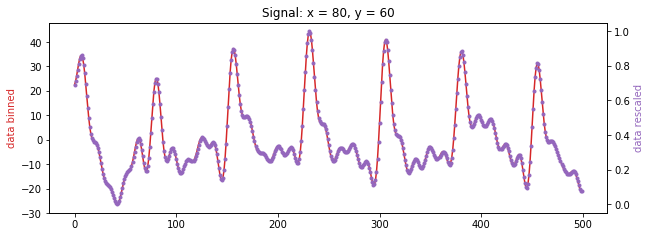

In [14]:
plt.figure(figsize = (10, 3.5))

plt.subplot(1, 2, 1)
frame = np.ma.masked_where(~mask, data_binned[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data binned, t = {t}".format(t = t))

plt.subplot(1, 2, 2)
frame = np.ma.masked_where(~mask, data_rescaled[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data rescaled, t = {t}".format(t = t))

plt.show()


fig, ax1 = plt.subplots(figsize = (10, 3.5))
ax1.plot(data_binned[y, x, :], color = "C3")
ax1.set_title("Signal: x = {x}, y = {y}".format(x=x, y=y))
ax1.set_ylabel("data binned", color='C3')

ax2 = ax1.twinx()
ax2.plot(data_rescaled[y, x, :], '.', color = "C4")
ax2.set_ylabel("data rescaled", color='C4')
plt.show()

<a id='section2.5'></a>
### Ensemble averaging

Now let's try to find *cycle length* of our signal and apply ensemble averaging.

In case of known *cycle length* (pacing cycle length (PCL) for example) just use it.

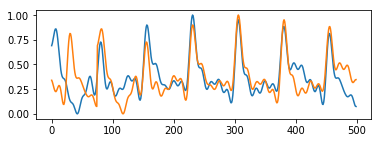

In [15]:
cycle_length = 75.
signal = data_rescaled[y, x]

plt.figure(figsize = (6, 2))
plt.plot(signal)
plt.plot(np.roll(signal, 75))
plt.show()

So it looks like *cycle_length = 75* is OK.

In [16]:
%time data_averaged = ensemble_average(data_rescaled, cycle_length)

CPU times: user 693 ms, sys: 0 ns, total: 693 ms
Wall time: 693 ms


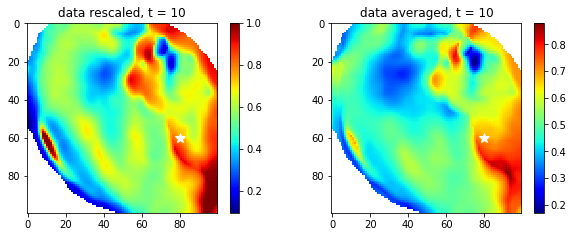

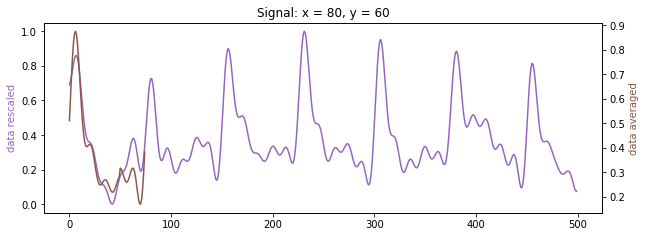

In [17]:
plt.figure(figsize = (10, 3.5))

plt.subplot(1, 2, 1)
frame = np.ma.masked_where(~mask, data_rescaled[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data rescaled, t = {t}".format(t = t))

plt.subplot(1, 2, 2)
frame = np.ma.masked_where(~mask, data_averaged[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data averaged, t = {t}".format(t = t))

plt.show()


fig, ax1 = plt.subplots(figsize = (10, 3.5))
ax1.plot(data_rescaled[y, x, :], color = "C4")
ax1.set_title("Signal: x = {x}, y = {y}".format(x=x, y=y))
ax1.set_ylabel("data rescaled", color='C4')

ax2 = ax1.twinx()
ax2.plot(data_averaged[y, x, :], color = "C5")
ax2.set_ylabel("data averaged", color='C5')
plt.show()

<a id='section2.6'></a>
### Transform to phase

In [18]:
%time phase = transform_to_phase(data_rescaled)

/home/andrey/WORK/bin/miniconda3/lib/python3.7/site-packages/pyCardiac/routines/routines.py:23: RuntimeWarning: All-NaN slice encountered
  result -= np.nanmin(result)
/home/andrey/WORK/bin/miniconda3/lib/python3.7/site-packages/pyCardiac/routines/routines.py:24: RuntimeWarning: All-NaN slice encountered
  result /= np.nanmax(result)


CPU times: user 1.12 s, sys: 56 ms, total: 1.17 s
Wall time: 1.17 s


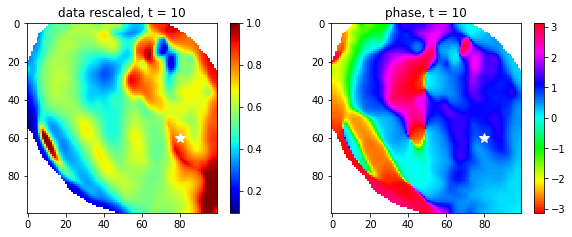

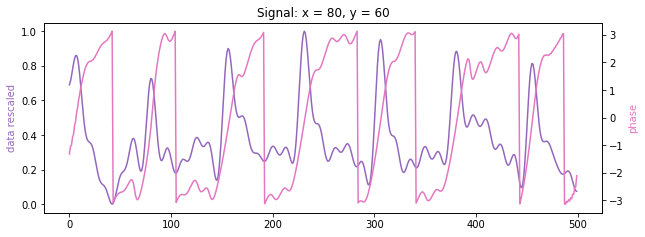

In [19]:
plt.figure(figsize = (10, 3.5))

plt.subplot(1, 2, 1)
frame = np.ma.masked_where(~mask, data_rescaled[:, :, t])
plt.imshow(frame, cmap = "jet")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("data rescaled, t = {t}".format(t = t))

plt.subplot(1, 2, 2)
frame = np.ma.masked_where(~mask, phase[:, :, t])
plt.imshow(frame, cmap = "hsv")
plt.plot(x, y, '*w', ms = 10)
plt.colorbar()
plt.title("phase, t = {t}".format(t = t))

plt.show()


fig, ax1 = plt.subplots(figsize = (10, 3.5))
ax1.plot(data_rescaled[y, x, :], color = "C4")
ax1.set_title("Signal: x = {x}, y = {y}".format(x=x, y=y))
ax1.set_ylabel("data rescaled", color='C4')

ax2 = ax1.twinx()
ax2.plot(phase[y, x, :], color = "C6")
ax2.set_ylabel("phase", color='C6')
plt.show()

<a id='section3'></a>
## Mapping

<a id='section3.1'></a>
### APD and Alternance maps

In [20]:
t_start, t_end = 200, 300
percentage = 60
%time apd_map = calculate_APD_map(data_rescaled, t_start, t_end, percentage).astype(float)

/home/andrey/WORK/bin/miniconda3/lib/python3.7/site-packages/pyCardiac/signal/analysis/calculate_APD.py:26: RuntimeWarning: invalid value encountered in less
  index = np.nonzero(signal_copy < signal_copy.min() + (1. - percentage / 100.) * signal_copy.ptp())


CPU times: user 520 ms, sys: 0 ns, total: 520 ms
Wall time: 520 ms


In [21]:
t_start, t_end = 200, 400
percentage = 60
%time alt_map = calculate_alternance_map(data_rescaled, t_start, t_end, percentage).astype(float)

/home/andrey/WORK/bin/miniconda3/lib/python3.7/site-packages/pyCardiac/signal/analysis/calculate_alternance.py:28: RuntimeWarning: invalid value encountered in less
  index = np.nonzero(signal_copy < signal_copy.min() + (1. - percentage / 100.) * signal_copy.ptp())


CPU times: user 436 ms, sys: 8.19 ms, total: 444 ms
Wall time: 436 ms


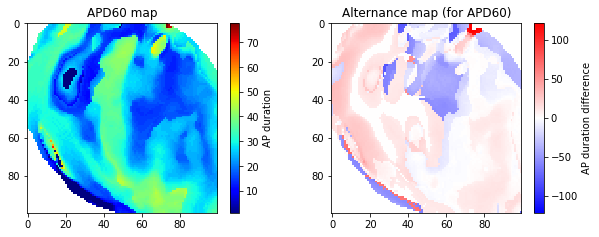

In [22]:
plt.figure(figsize = (10, 3.5))

plt.subplot(1, 2, 1)
frame = np.ma.masked_where(~mask, apd_map)
plt.imshow(frame, cmap = "jet")
plt.colorbar(label = "AP duration")
plt.title("APD{percentage} map".format(percentage = percentage))

plt.subplot(1, 2, 2)
frame = np.ma.masked_where(~mask, alt_map)
alt_abs = np.nanmax(np.abs(alt_map))
plt.imshow(frame, cmap = "bwr",
           vmin = -alt_abs, vmax = alt_abs)
plt.colorbar(label = "AP duration difference")
plt.title("Alternance map (for APD{percentage})".format(percentage = percentage))

plt.show()

<a id='section3.2'></a>
### Activation time map

In [27]:
t_start, t_end = 300, 310
%time act_map = calculate_activation_map(data_rescaled, t_start, t_end, 90.)

CPU times: user 221 ms, sys: 39.9 ms, total: 261 ms
Wall time: 218 ms


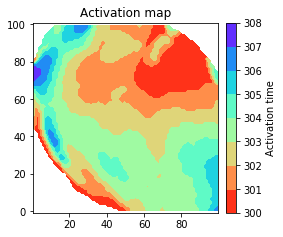

In [28]:
plt.figure(figsize = (1.1 * 3.5, 3.5))
frame = np.ma.masked_where(~mask, act_map)
frame = np.flipud(frame)
plt.contourf(frame, cmap = 'rainbow_r',
             origin = "lower")
plt.colorbar(label = "Activation time", fraction=0.1, pad=0.04)
plt.title("Activation map")
plt.axis('equal')

plt.show()

<a id='section3.3'></a>
### Phase singularity points (PS)

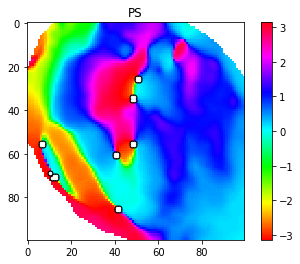

In [29]:
ps = phase_singularity_detection(phase[:, :, t])

plt.imshow(phase[:, :, t], cmap = 'hsv')
plt.colorbar()
plt.plot(ps[:, 1], ps[:, 0], 'k.', ms = 10)
plt.plot(ps[:, 1], ps[:, 0], 'w.', ms = 5)
plt.title("PS")
plt.show()